<h1 align="center">---- Data Science ----</h1>

----

**0) Packages**

In [ ]:
using Pkg
Pkg.add("Convex")
Pkg.add("SCS")
Pkg.add("Images")
Pkg.add("DelimitedFiles")

In [1]:
using Convex
using SCS
using CSV
using XLSX
using DataFrames
using Plots
using CSV
using Statistics
using Images
using DelimitedFiles

----

**Problem 1) Portfolio Investment**

Our first problem will be an investment problem. We will look at stock prices from three companies and decide how to spend an amount of $1000 on these three companies. Let's first load some data.

> Companies:

```
\ MSFT: Microsoft
\ FB: Facebook
\ AAPL: Apple
```

In [ ]:
# Reading the dataset and dropping first column
df = CSV.File("stock_prices.csv")  |> DataFrame
select!(df, Not(:Column1))

In [ ]:
# Replacing all commas by dots and converting the columns
# from String to Float 64
df.MSFT = replace.(df.MSFT, r"," => ".")
df.FB = replace.(df.FB, r"," => ".")
df.AAPL = replace.(df.AAPL, r"," => ".")

df.MSFT = parse.(Float64, df.MSFT)
df.FB = parse.(Float64, df.FB)
df.AAPL = parse.(Float64, df.AAPL)

df

In [ ]:
# Plotting to get a better overview of the data
plot(df[!, :MSFT], label="Microsoft")
plot!(df[!, :FB], label="Facebook")
plot!(df[!, :AAPL], label="Apple")

----

In [ ]:
# Converting the prices to a Matrix to be used
# later in the optimization problem
prices_matrix = Matrix(df)

To compute the weekly return, we will use the formula `R[i,t] - price[i, t-1]) / price[i, t-1]`. This is the return of stock `i` from week `t`.

In [ ]:
M1 = prices_matrix[1:end-1, :]
M2 = prices_matrix[2:end, :]
R = (M2 - M1)./M1

Now, let's work with the Risk Matrix.

In [ ]:
risk_matrix = cov(R)

In [ ]:
isposdef(risk_matrix)

In [ ]:
r = mean(R, dims=1)[:]

----

Okay, now that we prepared the data already, let's solve the following problem: Someone gives you $1000 and tells you to spend them in th form of investment on these three companies such that you get a return of 2% on what you spent.

The goal will be to minimize the rist, that is x'*risk_matrix. The constraints will be:

- `sum(x) = 1`, we will compute the percentage of investment rather than the exact amount;
- `dot(r,x) >= 0.02`;
- `x[1] >= 0`.

This problem is a convext problem, and we will use `Convex.jl` package to it.

In [ ]:
x = Variable(length(r))
problem = minimize(
    x' * risk_matrix * x
    , [sum(x)==1; r'*x>=0.02; x.>=0]
)

Note the `Convex.NotDcp` in the answer above and the warning, `Convex.jl`package requires that we pass Dcp compilant problem (Disciplined Convex Progamming).

In [ ]:
# making the problem DCP Compilant
problem = minimize(
    Convex.quadform(x, risk_matrix)
    , [sum(x)==1; r'*x>=0.02; x.>=0]
)

In [ ]:
solve!(problem, SCS.Optimizer)

In [ ]:
x

In [ ]:
sum(x.value)

In [ ]:
# getting the return
r'*x.value

In [ ]:
x.value .* 1000

----

**Problem 2) Image Recovery**

In this problem, we are given an image where some of the pixles have been altered. The goal is to recover the unknown pixels by solving an optimization problem. Let's first load the figure.

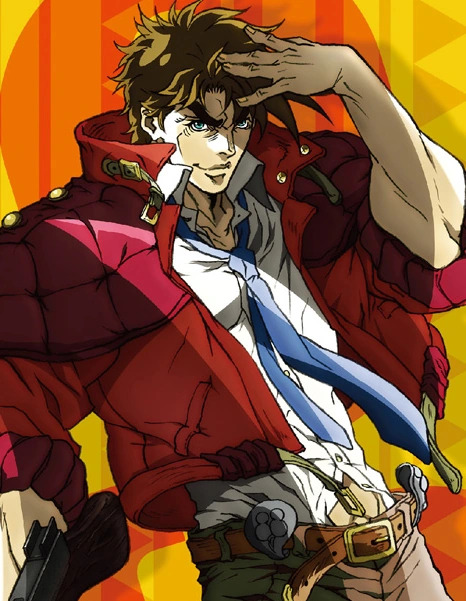

In [2]:
Kref = load("joseph_joestar.jpg")

We will convert the image to gray scale and disrupt some of the pixels (800.000 pixels to be precise).

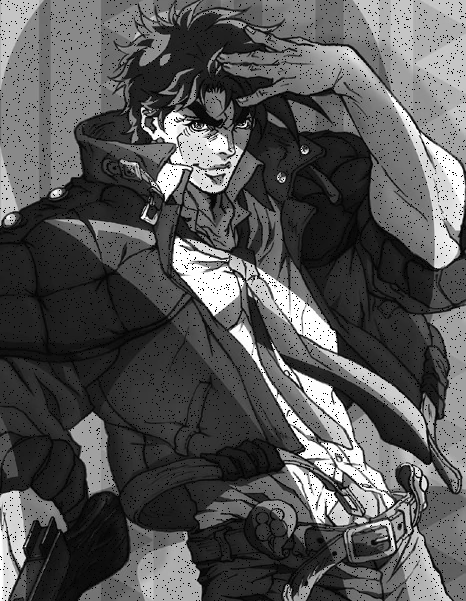

In [10]:
K = copy(Kref)
p = prod(size(K))
missing_ids = rand(1:p, 10000)
K[missing_ids] .= RGBX{N0f8}(0.0, 0.0, 0.0)
K
Gray.(K)

In [11]:
# converting the corrupted image to array of numbers.
Y = Float64.(Gray.(K))

601×466 Matrix{Float64}:
 0.0       0.760784  0.772549  0.772549  …  0.772549  0.772549  0.772549
 0.694118  0.760784  0.772549  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.772549  0.772549     0.772549  0.772549  0.772549
 0.694118  0.0       0.772549  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.772549  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.772549  0.772549  …  0.772549  0.772549  0.772549
 0.694118  0.760784  0.772549  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.772549  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.776471  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.776471  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.776471  0.772549  …  0.772549  0.772549  0.772549
 0.694118  0.760784  0.776471  0.772549     0.772549  0.772549  0.772549
 0.694118  0.760784  0.776471  0.772549     0.772549  0.772549  0.772549
 ⋮                        

Given this image, the goal is now to compute the matrix. We will use a common technique for this problem developed by Candes and Tao. The goal will be to create a new matrix `X` where we minimize the nuclear norm of `X` (i.e. sum of the singular values of `X`), and such that the entries that are already known in `Y` remain the same in `X`. We will again use `Convex.jl` package to solve this problem. Let's write it down below.

In [12]:
correct_ids = findall(Y[:].!=0)
X = Convex.Variable(size(Y))
problem = minimize(nuclearnorm(X))
problem.constraints += X[correct_ids]==Y[correct_ids]

1-element Vector{Constraint}:
 == constraint (affine)
├─ index (affine; real)
│  └─ 601×466 real variable (id: 984…629)
└─ 270233-element Vector{Float64}

In [13]:
# solve!(problem, SCS.Optimizer(eps=1e-3, alpha=1.5))
solve!(problem, SCS.Optimizer())

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 858424, constraints m: 1408723
cones: 	  z: primal zero / dual free vars: 838945
	  s: psd vars: 569778, ssize: 1
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 1418369, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|1.58e+001 9.92e-001 2.25e+004 3.71e+003 1.00e-001 5.07e+000 
   175|3.40e-004 2.37e-005 5.23e-007 1.36e+003 1.00e-001 3.36e+002 
---

norm(float.(Gray.(Kref)) - X.value) = 5.272872847857197
norm(-(X.value)) = 233.9985614937646


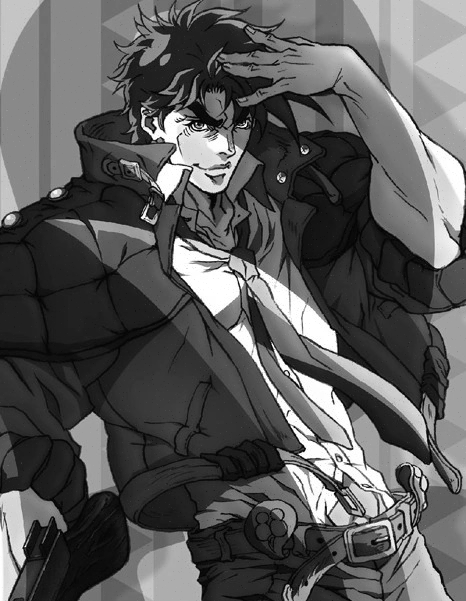

In [14]:
@show norm(float.(Gray.(Kref)) - X.value)
@show norm(-X.value)
colorview(Gray, X.value)